In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint, uniform
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# Set plotting style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [3]:

%cd '/content/drive/MyDrive/DATA 245/Project'

/content/drive/.shortcut-targets-by-id/1dBaisw15vXAkSJcnz0pO83MeXqW6AHFn/DATA 245/Project


In [4]:

file_path = '02 artifacts/processed_dataset_WQ.pkl'

try:
    df = pd.read_pickle(file_path)
    print(f"Successfully read '{file_path}'")


    if 'sample_date' in df.columns:
        df['sample_date'] = pd.to_datetime(df['sample_date'])
        df = df.set_index('sample_date').sort_index()

    target_col = 'DissolvedOxygen_mg/L'
    feature_cols = ['SpecificConductance_µS/cm', 'Turbidity_NTU', 'WaterTemperature_°C', 'pH_pH units', 'sample_depth_meter']

    data = df[[target_col] + feature_cols].copy()

    display(data.head())

except FileNotFoundError:
    print(f"File not found at {file_path}.")

Successfully read '02 artifacts/processed_dataset_WQ.pkl'


,DissolvedOxygen_mg/L,SpecificConductance_µS/cm,Turbidity_NTU,WaterTemperature_°C,pH_pH units,sample_depth_meter
sample_date,,,,,,
2000-01-03 09:55:00,11.5,182.0,5.98,8.8,7.5,1.0
2000-01-03 10:55:00,11.5,55.0,2.80,9.5,8.0,1.0
2000-01-03 11:35:00,11.6,486.0,15.40,9.1,7.9,1.0
2000-01-03 12:40:00,11.2,167.0,8.45,9.7,7.9,1.0
2000-01-04 10:45:00,4.0,949.0,49.30,8.7,6.8,1.0


In [5]:
# 1. Reset column names to match original dataframe
target_col = 'DissolvedOxygen_mg/L'
feature_cols = ['SpecificConductance_µS/cm', 'Turbidity_NTU', 'WaterTemperature_°C', 'pH_pH units', 'sample_depth_meter']

# 2. Resample to daily frequency
# ensuring we select only the columns we need from the original df
df_daily = df[[target_col] + feature_cols].resample('D').mean().dropna()
print(f"Daily Resampled Data: {len(df_daily)} records ending on {df_daily.index.max().date()}")

display(df_daily.tail())

# 3. Define Parameter Grids

xgb_param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(3, 6),
    'learning_rate': uniform(0.05, 0.15)
}

rf_param_dist = {
    'n_estimators': randint(100, 200),
    'max_depth': randint(5, 10)
}

svr_param_dist = {
    'svr__C': uniform(0.1, 5),
    'svr__epsilon': uniform(0.01, 0.5)
}

Daily Resampled Data: 5393 records ending on 2025-07-08


,DissolvedOxygen_mg/L,SpecificConductance_µS/cm,Turbidity_NTU,WaterTemperature_°C,pH_pH units,sample_depth_meter
sample_date,,,,,,
2025-06-25,7.760000,186.133333,2.413333,22.501667,7.740000,1.000000
2025-06-26,7.566667,207.666667,3.826667,23.162000,7.650000,1.000000
2025-07-01,8.053333,375.000000,19.680000,21.383333,7.710000,1.000000
2025-07-07,8.860000,271.000000,7.800000,22.600000,7.710000,0.000000
2025-07-08,8.283333,286.666667,51.180000,20.473333,7.783333,0.666667


In [6]:
forecast_horizons = range(1, 16)
forecast_results = []
metrics_log = []

# 2. Copy dataframe
df_features = df_daily.copy()

# 3. Target Lags (1-7)
for i in range(1, 8):
    df_features[f'{target_col}_lag_{i}'] = df_features[target_col].shift(i)

# 4. Rolling stats and other features
for col in [target_col] + feature_cols:
    # a. Current value
    # Note: We add a suffix to distinguish, though we will rename the main target column later too.
    df_features[f'{col}_current'] = df_features[col]

    # b. Rolling Mean (7 days)
    df_features[f'{col}_roll_7_mean'] = df_features[col].rolling(window=7).mean()

    # c. Rolling Std (7 days)
    df_features[f'{col}_roll_7_std'] = df_features[col].rolling(window=7).std()

    # d. 1-day lag (specifically for feature columns)
    if col != target_col:
        df_features[f'{col}_lag_1'] = df_features[col].shift(1)

# 5. Cyclical Features
df_features['sin'] = np.sin(2 * np.pi * df_features.index.dayofyear / 365.25)
df_features['cos'] = np.cos(2 * np.pi * df_features.index.dayofyear / 365.25)

# 6. Rename primary target column to indicate it's the 'Current' state (predictor)
df_features = df_features.rename(columns={target_col: f"{target_col}_Current"})

# 7. Drop NaNs created by lags/rolling
df_features = df_features.dropna()

# 8. Update target_col variable
target_col = f"{target_col}_Current"

print(f"Feature Engineering Complete. New feature set shape: {df_features.shape}")
display(df_features.head(3))

Feature Engineering Complete. New feature set shape: (5386, 38)


,DissolvedOxygen_mg/L_Current,SpecificConductance_µS/cm,Turbidity_NTU,WaterTemperature_°C,pH_pH units,sample_depth_meter,DissolvedOxygen_mg/L_lag_1,DissolvedOxygen_mg/L_lag_2,DissolvedOxygen_mg/L_lag_3,DissolvedOxygen_mg/L_lag_4,...,pH_pH units_current,pH_pH units_roll_7_mean,pH_pH units_roll_7_std,pH_pH units_lag_1,sample_depth_meter_current,sample_depth_meter_roll_7_mean,sample_depth_meter_roll_7_std,sample_depth_meter_lag_1,sin,cos
sample_date,,,,,,,,,,,,,,,,,,,,,
2000-01-12,8.860000,465.800000,33.180000,12.420000,7.704,0.948640,9.914286,10.425000,8.900000,9.900,...,7.704,7.602941,0.360187,7.257143,0.948640,0.763082,0.370644,0.150000,0.204966,0.978769
2000-01-13,10.166667,434.833333,28.166667,9.556667,7.625,0.928667,8.860000,9.914286,10.425000,8.900,...,7.625,7.606512,0.360277,7.704000,0.928667,0.752891,0.363965,0.948640,0.221772,0.975099
2000-01-14,9.600000,12886.666667,24.500000,9.966667,7.710,0.914400,10.166667,8.860000,9.914286,10.425,...,7.710,7.693020,0.284326,7.625000,0.914400,0.742701,0.357297,0.928667,0.238513,0.971139


In [7]:
import joblib
import json
import os
from datetime import datetime
# --- Helper Functions ---

def save_forecast_model(model, feature_names, horizon, metrics, model_name, run_id, output_dir='02 artifacts/models'):
    os.makedirs(output_dir, exist_ok=True)
    base_name = f'{model_name.lower()}_h{horizon}_{run_id}'

    # Save model
    model_path = os.path.join(output_dir, f'{base_name}.pkl')
    joblib.dump(model, model_path)

    # Save metadata
    metadata = {
        'horizon_days': horizon,
        'feature_names': feature_names,
        'metrics': metrics,
        'model_params': getattr(model, "get_params", lambda: {} )(),
        'model_name': model_name,
        'run_id': run_id,
        'timestamp': datetime.now().isoformat(timespec='seconds')
    }

    metadata_path = os.path.join(output_dir, f'{base_name}_metadata.json')
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2, default=str)

    return model_path, metadata_path

def load_forecast_model(model_path):
    model = joblib.load(model_path)
    metadata_path = model_path.replace('.pkl', '_metadata.json')
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
    return model, metadata

# --- Model Training & Comparison ---

split_date = df_features.index.max() - pd.Timedelta(days=60)
train_mask = df_features.index <= split_date
valid_mask = df_features.index > split_date

print(f"Training models for {len(forecast_horizons)} horizons with RandomizedSearchCV...")
latest_row = df_features.iloc[[-1]]
saved_models = {}

# Define models configuration
models_config = {
    'XGBoost': {
        'estimator': XGBRegressor(n_jobs=1, random_state=42),
        'params': xgb_param_dist
    },
    'RandomForest': {
        'estimator': RandomForestRegressor(n_jobs=1, random_state=42),
        'params': rf_param_dist
    },
    'SVR': {
        'estimator': make_pipeline(StandardScaler(), SVR()),
        'params': svr_param_dist
    }
}

for h in forecast_horizons:
    print(f"Optimizing Horizon {h}...")
    # single run id per horizon to avoid filename collisions and keep runs grouped
    run_id = datetime.now().strftime('%Y%m%d_%H%M%S_%f')

    # --- A. Target Transformation ---
    y = df_features[target_col].shift(-h) - df_features[target_col]
    X = df_features

    valid_idx = y.dropna().index

    X_train = X.loc[valid_idx.intersection(df_features[train_mask].index)]
    y_train = y.loc[X_train.index]

    X_valid = X.loc[valid_idx.intersection(df_features[valid_mask].index)]
    y_valid = y.loc[X_valid.index]

    tscv = TimeSeriesSplit(n_splits=3)

    best_horizon_model_name = None
    best_horizon_rmse = float('inf')
    best_horizon_forecast_entry = None

    # --- Loop through Models ---
    for model_name, config in models_config.items():
        search = RandomizedSearchCV(
            estimator=config['estimator'],
            param_distributions=config['params'],
            n_iter=2,
            scoring='neg_root_mean_squared_error',
            cv=tscv,
            n_jobs=-1,
            verbose=0,
            random_state=42
        )

        search.fit(X_train, y_train)
        model = search.best_estimator_

        # --- Validation ---
        preds_valid = model.predict(X_valid)
        val_current_vals = df_features.loc[X_valid.index, target_col]

        pred_raw = val_current_vals + preds_valid
        actual_raw = val_current_vals + y_valid

        rmse = np.sqrt(mean_squared_error(actual_raw, pred_raw))
        mae = mean_absolute_error(actual_raw, pred_raw)
        naive_rmse = np.sqrt(mean_squared_error(actual_raw, val_current_vals))

        metrics = {
            'Horizon_Days': h,
            'Model': model_name,
            'Model_RMSE': rmse,
            'Naive_RMSE': naive_rmse,
            'Model_MAE': mae,
            'Improvement_vs_Naive': (naive_rmse - rmse) / naive_rmse if naive_rmse != 0 else None,
            'Best_Params': search.best_params_
        }
        metrics_log.append(metrics)

        # Save Model (all three get saved with unique names)
        model_path, meta_path = save_forecast_model(
            model=model,
            feature_names=X_train.columns.tolist(),
            horizon=h,
            metrics=metrics,
            model_name=model_name,
            run_id=run_id,
            output_dir='02 artifacts/models'
        )
        saved_models[(h, model_name)] = model_path

        # --- Track Best Model for Forecast ---
        if rmse < best_horizon_rmse:
            best_horizon_rmse = rmse
            best_horizon_model_name = model_name

            pred_change = model.predict(latest_row)[0]
            current_val = latest_row[target_col].item()
            pred_val = current_val + pred_change
            future_date = latest_row.index[0] + pd.Timedelta(days=h)

            errors = y_valid - preds_valid
            q05 = np.percentile(errors, 5)
            q95 = np.percentile(errors, 95)

            best_horizon_forecast_entry = {
                'sample_date': future_date,
                'Value': pred_val,
                'Type': 'Forecast',
                'Lower_Bound': pred_val + q05,
                'Upper_Bound': pred_val + q95,
                'Model_Used': model_name
            }

    if best_horizon_forecast_entry:
        forecast_results.append(best_horizon_forecast_entry)

# --- Prepare Summary Dataframes ---
history_df = df_daily.iloc[-15:].copy()
history_df['Type'] = 'History'
history_df['Lower_Bound'] = np.nan
history_df['Upper_Bound'] = np.nan
history_df['Model_Used'] = 'History'
history_val_col = 'DissolvedOxygen_mg/L'
history_df = history_df[[history_val_col, 'Type', 'Lower_Bound', 'Upper_Bound', 'Model_Used']].rename(columns={history_val_col: 'Value'})

forecast_df = pd.DataFrame(forecast_results).set_index('sample_date')
full_df = pd.concat([history_df, forecast_df])

print("\n--- Last 15 Days History & Next 15 Days Forecast (Best Models) ---")
display(full_df)
print("\nTop performing models per horizon:")
display(forecast_df[['Value', 'Model_Used']])

Training models for 15 horizons with RandomizedSearchCV...
Optimizing Horizon 1...
Optimizing Horizon 2...
Optimizing Horizon 3...
Optimizing Horizon 4...
Optimizing Horizon 5...
Optimizing Horizon 6...
Optimizing Horizon 7...
Optimizing Horizon 8...
Optimizing Horizon 9...
Optimizing Horizon 10...
Optimizing Horizon 11...
Optimizing Horizon 12...
Optimizing Horizon 13...
Optimizing Horizon 14...
Optimizing Horizon 15...

--- Last 15 Days History & Next 15 Days Forecast (Best Models) ---


,Value,Type,Lower_Bound,Upper_Bound,Model_Used
sample_date,,,,,
2025-06-03,8.020000,History,NaN,NaN,History
2025-06-04,6.918000,History,NaN,NaN,History
2025-06-05,8.673333,History,NaN,NaN,History
2025-06-10,7.590000,History,NaN,NaN,History
2025-06-11,8.336667,History,NaN,NaN,History
2025-06-17,10.219417,History,NaN,NaN,History
2025-06-18,8.042857,History,NaN,NaN,History
2025-06-19,8.504000,History,NaN,NaN,History
2025-06-23,8.860000,History,NaN,NaN,History



Top performing models per horizon:


,Value,Model_Used
sample_date,,
2025-07-09,8.365743,SVR
2025-07-10,8.304156,SVR
2025-07-11,8.346707,RandomForest
2025-07-12,8.124842,RandomForest
2025-07-13,8.141298,RandomForest
2025-07-14,8.128501,XGBoost
2025-07-15,8.257535,XGBoost
2025-07-16,8.126965,RandomForest
2025-07-17,8.162787,XGBoost


In [8]:
# Filter metrics for horizon 1
h1_metrics = [m for m in metrics_log if m['Horizon_Days'] == 1]

# Find best model based on RMSE
best_h1_entry = min(h1_metrics, key=lambda x: x['Model_RMSE'])
best_h1_model_name = best_h1_entry['Model']
best_h1_rmse = best_h1_entry['Model_RMSE']

print(f"Best model for Horizon 1: {best_h1_model_name} with RMSE: {best_h1_rmse:.4f}")

# Get file path
model_path = saved_models[(1, best_h1_model_name)]

# Load model
best_h1_model, metadata = load_forecast_model(model_path)
print(f"Loaded model from {model_path}")

Best model for Horizon 1: SVR with RMSE: 0.7686
Loaded model from 02 artifacts/models/svr_h1_20251123_035446_759917.pkl


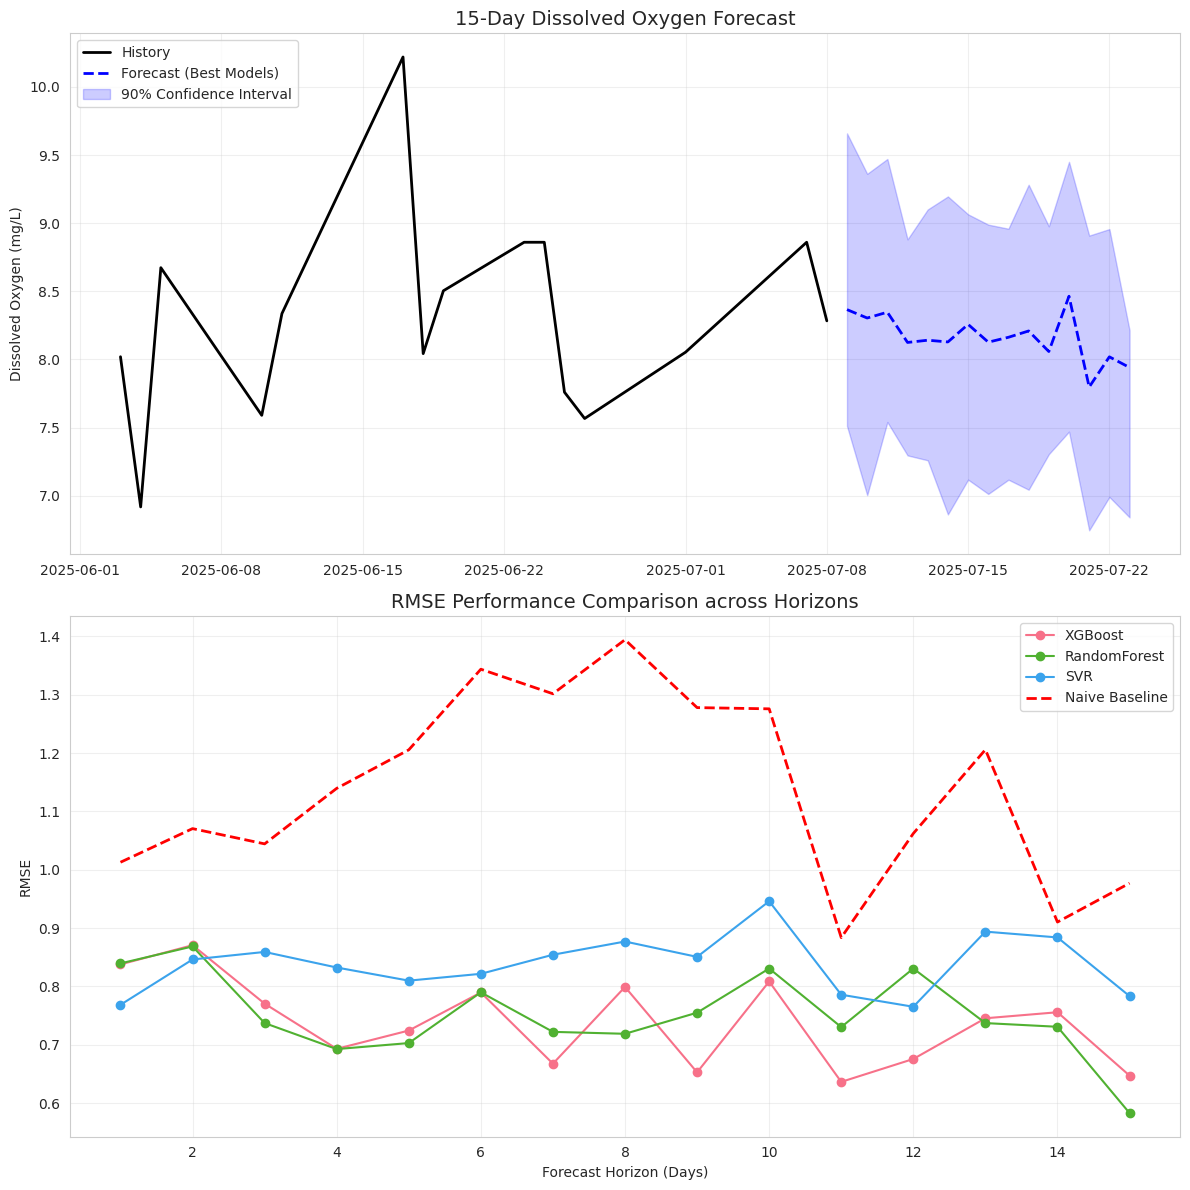

In [21]:
metrics_df = pd.DataFrame(metrics_log)

fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# --- Subplot 1: Forecast Visualization ---
ax = axes[0]

# Plot History
history_data = full_df[full_df['Type'] == 'History']
ax.plot(history_data.index, history_data['Value'], label='History', color='black', linewidth=2)

# Plot Forecast
forecast_data = full_df[full_df['Type'] == 'Forecast']
ax.plot(forecast_data.index, forecast_data['Value'], label='Forecast (Best Models)', color='blue', linestyle='--', linewidth=2)

# Confidence Interval
ax.fill_between(forecast_data.index,
                forecast_data['Lower_Bound'],
                forecast_data['Upper_Bound'],
                color='blue', alpha=0.2, label='90% Confidence Interval')

ax.set_title('15-Day Dissolved Oxygen Forecast', fontsize=14)
ax.set_ylabel('Dissolved Oxygen (mg/L)')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

# --- Subplot 2: RMSE Comparison ---
ax = axes[1]

models = metrics_df['Model'].unique()
colors = sns.color_palette("husl", len(models))

for model, color in zip(models, colors):
    subset = metrics_df[metrics_df['Model'] == model]
    ax.plot(subset['Horizon_Days'], subset['Model_RMSE'], marker='o', label=f'{model}', color=color)

# Naive Baseline (Using the first model's naive entries as they should be identical per horizon)
naive_data = metrics_df[metrics_df['Model'] == models[0]].sort_values('Horizon_Days')
ax.plot(naive_data['Horizon_Days'], naive_data['Naive_RMSE'],
        color='red', linestyle='--', linewidth=2, label='Naive Baseline')

ax.set_title('RMSE Performance Comparison across Horizons', fontsize=14)
ax.set_xlabel('Forecast Horizon (Days)')
ax.set_ylabel('RMSE')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
ax = axes[1]

models = metrics_df['Model'].unique()
colors = sns.color_palette("husl", len(models))

for model, color in zip(models, colors):
    subset = metrics_df[metrics_df['Model'] == model]
    ax.plot(subset['Horizon_Days'], subset['Model_MAE'], marker='o', label=f'{model}', color=color)

ax.set_title('MAE Performance Comparison across Horizons', fontsize=14)
ax.set_xlabel('Forecast Horizon (Days)')
ax.set_ylabel('MAE')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

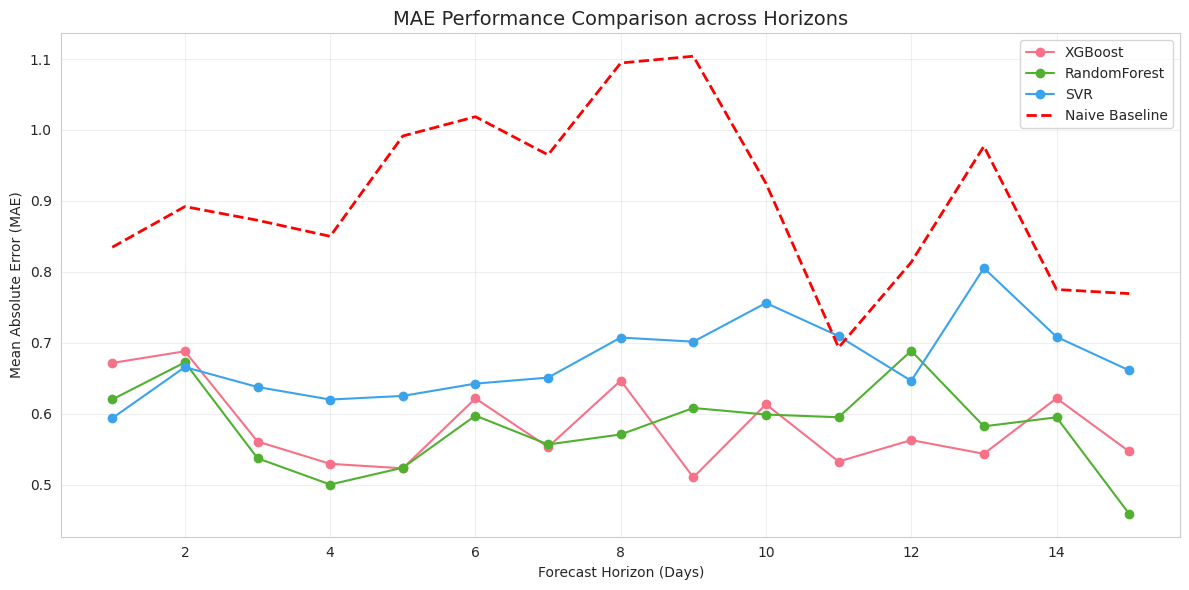

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error

# 1. Calculate Naive MAE for comparison
naive_mae_per_horizon = []
split_date = df_features.index.max() - pd.Timedelta(days=60)
valid_mask = df_features.index > split_date

for h in sorted(metrics_df['Horizon_Days'].unique()):
    # Future value (Actual)
    y_future = df_features[target_col].shift(-h)
    # Current value (Naive Prediction)
    y_current = df_features[target_col]

    # Filter for validation set
    # We must ensure indices align and drop NaNs created by shift
    valid_idx = df_features.index[valid_mask]

    # Align on validation index
    actuals = y_future.loc[valid_idx]
    preds = y_current.loc[valid_idx]

    # Drop any resulting NaNs (e.g. at the very end of the dataset)
    mask = ~actuals.isna() & ~preds.isna()

    if mask.sum() > 0:
        mae = mean_absolute_error(actuals[mask], preds[mask])
        naive_mae_per_horizon.append({'Horizon_Days': h, 'Naive_MAE': mae})

naive_mae_df = pd.DataFrame(naive_mae_per_horizon)

# 2. Plot MAE
plt.figure(figsize=(12, 6))

models = metrics_df['Model'].unique()
colors = sns.color_palette("husl", len(models))

# Plot trained models
for model, color in zip(models, colors):
    subset = metrics_df[metrics_df['Model'] == model].sort_values('Horizon_Days')
    plt.plot(subset['Horizon_Days'], subset['Model_MAE'], marker='o', label=f'{model}', color=color)

# Plot Naive Baseline
if not naive_mae_df.empty:
    plt.plot(naive_mae_df['Horizon_Days'], naive_mae_df['Naive_MAE'],
             color='red', linestyle='--', linewidth=2, label='Naive Baseline')

plt.title('MAE Performance Comparison across Horizons', fontsize=14)
plt.xlabel('Forecast Horizon (Days)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [14]:
%ls '02 artifacts'/'models'

randomforest_h10_20251123_041034_259145_metadata.json
randomforest_h10_20251123_041034_259145.pkl
randomforest_h11_20251123_041218_008116_metadata.json
randomforest_h11_20251123_041218_008116.pkl
randomforest_h1_20251123_035446_759917_metadata.json
randomforest_h1_20251123_035446_759917.pkl
randomforest_h12_20251123_041407_253555_metadata.json
randomforest_h12_20251123_041407_253555.pkl
randomforest_h13_20251123_041552_031242_metadata.json
randomforest_h13_20251123_041552_031242.pkl
randomforest_h14_20251123_041735_997435_metadata.json
randomforest_h14_20251123_041735_997435.pkl
randomforest_h15_20251123_041920_471480_metadata.json
randomforest_h15_20251123_041920_471480.pkl
randomforest_h2_20251123_035637_076594_metadata.json
randomforest_h2_20251123_035637_076594.pkl
randomforest_h3_20251123_035822_552538_metadata.json
randomforest_h3_20251123_035822_552538.pkl
randomforest_h4_20251123_040006_761427_metadata.json
randomforest_h4_20251123_040006_761427.pkl
randomforest_h5_20251123_040

Loaded XGBoost model for Horizon 15 from: 02 artifacts/models/xgboost_h15_20251123_041920_471480.pkl


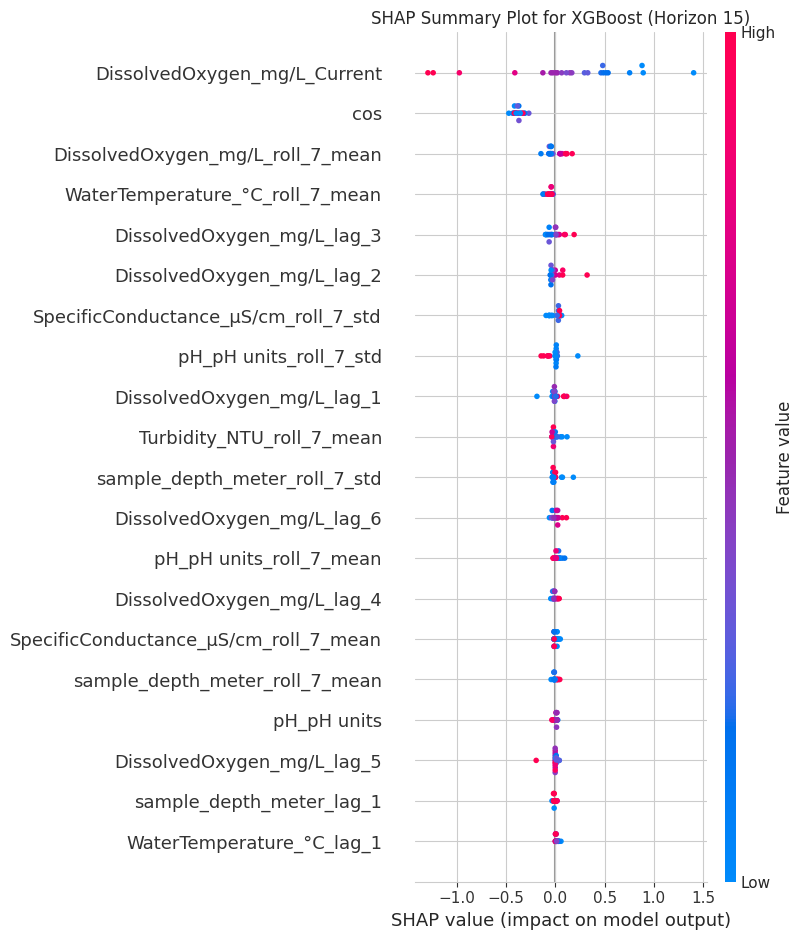

In [17]:
import shap
import matplotlib.pyplot as plt

# 1. Load the saved XGBoost model for Horizon 15
horizon = 15
model_key = (horizon, 'XGBoost')

if model_key in saved_models:
    xgb_model_path = saved_models[model_key]
    xgb_model_h15, metadata = load_forecast_model(xgb_model_path)
    print(f"Loaded XGBoost model for Horizon {horizon} from: {xgb_model_path}")

    # 2. Prepare the validation data
    # We use the same validation split defined earlier
    split_date = df_features.index.max() - pd.Timedelta(days=60)
    valid_mask = df_features.index > split_date
    X_valid = df_features[valid_mask]

    # 3. Calculate SHAP values
    # (initjs is usually required once per notebook, but safe to call again)
    shap.initjs()

    explainer = shap.TreeExplainer(xgb_model_h15)
    shap_values_h15 = explainer.shap_values(X_valid)

    # 4. Generate Summary Plot
    plt.title(f"SHAP Summary Plot for XGBoost (Horizon {horizon})")
    shap.summary_plot(shap_values_h15, X_valid, show=True)
else:
    print(f"XGBoost model for Horizon {horizon} not found in saved_models.")

In [18]:
import pandas as pd
import numpy as np

# 1. Calculate Global Feature Importance (Mean Absolute SHAP Value)
feature_importance = pd.DataFrame(
    list(zip(X_valid.columns, np.abs(shap_values_h15).mean(0))),
    columns=['Feature', 'Mean_Abs_SHAP']
)
feature_importance.sort_values(by=['Mean_Abs_SHAP'], ascending=False, inplace=True)

# 2. Determine Relationship Direction (Correlation between Feature Value and SHAP Value)
# If Corr > 0: Higher feature value -> Higher predicted DO (Positive impact)
# If Corr < 0: Higher feature value -> Lower predicted DO (Negative impact)
top_n = 10
top_features_df = feature_importance.head(top_n).copy()

directions = []
for feature in top_features_df['Feature']:
    feature_idx = X_valid.columns.get_loc(feature)
    # Correlation between the raw feature values and their corresponding SHAP values
    corr = np.corrcoef(X_valid[feature].values.astype(float), shap_values_h15[:, feature_idx])[0, 1]

    if corr > 0.1:
        direction = "Positive (+)"
        desc = "Higher value increases forecast"
    elif corr < -0.1:
        direction = "Negative (-)"
        desc = "Higher value decreases forecast"
    else:
        direction = "Complex/Non-linear"
        desc = "Relationship is not strictly linear"

    directions.append((direction, desc))

top_features_df['Relationship'] = [d[0] for d in directions]
top_features_df['Interpretation'] = [d[1] for d in directions]

print(f"--- Top {top_n} Features Driving the 15-Day Forecast ---")
display(top_features_df.style.background_gradient(subset=['Mean_Abs_SHAP'], cmap='viridis'))

--- Top 10 Features Driving the 15-Day Forecast ---


,Feature,Mean_Abs_SHAP,Relationship,Interpretation
0,DissolvedOxygen_mg/L_Current,0.486457,Negative (-),Higher value decreases forecast
37,cos,0.379788,Complex/Non-linear,Relationship is not strictly linear
14,DissolvedOxygen_mg/L_roll_7_mean,0.066609,Positive (+),Higher value increases forecast
25,WaterTemperature_°C_roll_7_mean,0.055663,Positive (+),Higher value increases forecast
8,DissolvedOxygen_mg/L_lag_3,0.054820,Positive (+),Higher value increases forecast
7,DissolvedOxygen_mg/L_lag_2,0.049645,Positive (+),Higher value increases forecast
18,SpecificConductance_µS/cm_roll_7_std,0.044412,Positive (+),Higher value increases forecast
30,pH_pH units_roll_7_std,0.038580,Negative (-),Higher value decreases forecast
6,DissolvedOxygen_mg/L_lag_1,0.034643,Positive (+),Higher value increases forecast
21,Turbidity_NTU_roll_7_mean,0.028492,Negative (-),Higher value decreases forecast


Loaded RandomForest model for Horizon 15 from: 02 artifacts/models/randomforest_h15_20251123_041920_471480.pkl


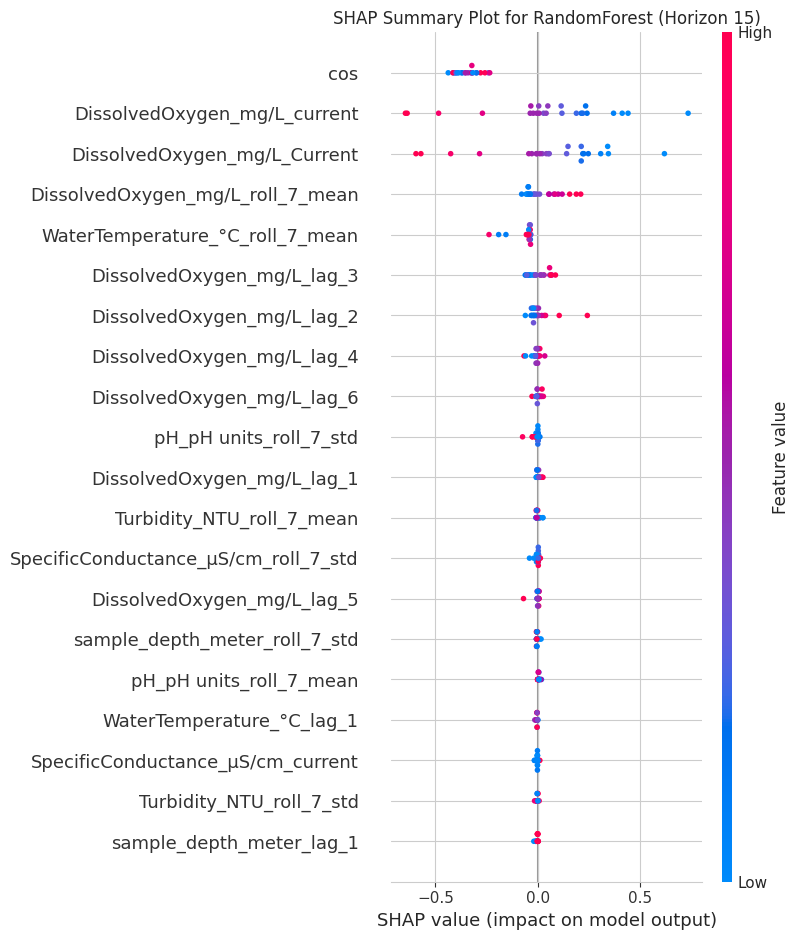

In [22]:
import shap
import matplotlib.pyplot as plt

# 1. Load the saved RandomForest model for Horizon 15
horizon = 15
model_name = 'RandomForest'
model_key = (horizon, model_name)

if model_key in saved_models:
    rf_model_path = saved_models[model_key]
    rf_model_h15, metadata = load_forecast_model(rf_model_path)
    print(f"Loaded {model_name} model for Horizon {horizon} from: {rf_model_path}")

    # 2. Prepare the validation data
    split_date = df_features.index.max() - pd.Timedelta(days=60)
    valid_mask = df_features.index > split_date
    X_valid = df_features[valid_mask]

    # 3. Calculate SHAP values
    # shap.initjs() # Not strictly necessary if already initialized, but good for standalone

    # Note: TreeExplainer works for sklearn RandomForestRegressor
    explainer = shap.TreeExplainer(rf_model_h15)
    shap_values_rf = explainer.shap_values(X_valid)

    # 4. Generate Summary Plot
    plt.title(f"SHAP Summary Plot for {model_name} (Horizon {horizon})")
    shap.summary_plot(shap_values_rf, X_valid, show=True)
else:
    print(f"{model_name} model for Horizon {horizon} not found in saved_models.")

In [24]:
# 1. Calculate Global Feature Importance (Mean Absolute SHAP Value) for RandomForest
feature_importance_rf = pd.DataFrame(
    list(zip(X_valid.columns, np.abs(shap_values_rf).mean(0))),
    columns=['Feature', 'Mean_Abs_SHAP']
)
feature_importance_rf.sort_values(by=['Mean_Abs_SHAP'], ascending=False, inplace=True)

# 2. Determine Relationship Direction (Correlation between Feature Value and SHAP Value)
top_n = 10
top_features_rf_df = feature_importance_rf.head(top_n).copy()

directions = []
for feature in top_features_rf_df['Feature']:
    feature_idx = X_valid.columns.get_loc(feature)
    # Correlation between the raw feature values and their corresponding SHAP values from RandomForest
    corr = np.corrcoef(X_valid[feature].values.astype(float), shap_values_rf[:, feature_idx])[0, 1]

    if corr > 0.1:
        direction = "Positive (+)"
        desc = "Higher value increases forecast"
    elif corr < -0.1:
        direction = "Negative (-)"
        desc = "Higher value decreases forecast"
    else:
        direction = "Complex/Non-linear"
        desc = "Relationship is not strictly linear"

    directions.append((direction, desc))

top_features_rf_df['Relationship'] = [d[0] for d in directions]
top_features_rf_df['Interpretation'] = [d[1] for d in directions]

print(f"--- Top {top_n} Features Driving the 15-Day Forecast (RandomForest) ---")
display(top_features_rf_df.style.background_gradient(subset=['Mean_Abs_SHAP'], cmap='viridis'))

--- Top 10 Features Driving the 15-Day Forecast (RandomForest) ---


,Feature,Mean_Abs_SHAP,Relationship,Interpretation
37,cos,0.344357,Positive (+),Higher value increases forecast
13,DissolvedOxygen_mg/L_current,0.231521,Negative (-),Higher value decreases forecast
0,DissolvedOxygen_mg/L_Current,0.215132,Negative (-),Higher value decreases forecast
14,DissolvedOxygen_mg/L_roll_7_mean,0.066645,Positive (+),Higher value increases forecast
25,WaterTemperature_°C_roll_7_mean,0.061138,Positive (+),Higher value increases forecast
8,DissolvedOxygen_mg/L_lag_3,0.039759,Positive (+),Higher value increases forecast
7,DissolvedOxygen_mg/L_lag_2,0.032711,Positive (+),Higher value increases forecast
9,DissolvedOxygen_mg/L_lag_4,0.013496,Positive (+),Higher value increases forecast
11,DissolvedOxygen_mg/L_lag_6,0.009011,Positive (+),Higher value increases forecast
30,pH_pH units_roll_7_std,0.008549,Negative (-),Higher value decreases forecast


In [19]:
# Filter metrics for Horizon 15
h15_metrics_df = metrics_df[metrics_df['Horizon_Days'] == 15].copy()

# Select and rename columns for clarity
comparison_table = h15_metrics_df[
    ['Model', 'Model_RMSE', 'Model_MAE', 'Naive_RMSE', 'Improvement_vs_Naive']
].sort_values(by='Model_RMSE')

# Format the columns for better readability
comparison_table['Improvement_vs_Naive'] = comparison_table['Improvement_vs_Naive'].apply(lambda x: f"{x:.2%}")
comparison_table = comparison_table.round(4)

print("--- 15-Day Forecast Model Performance Comparison ---")
display(comparison_table)

--- 15-Day Forecast Model Performance Comparison ---


,Model,Model_RMSE,Model_MAE,Naive_RMSE,Improvement_vs_Naive
43,RandomForest,0.5830,0.4587,0.977,40.33%
42,XGBoost,0.6472,0.5467,0.977,33.76%
44,SVR,0.7835,0.6611,0.977,19.81%
